# Main Problem

> **How can we improve the relevance of recommendations or search results on Corner?**

---

## Context:
Corner's search system sometimes returns **irrelevant results**.  
For example:
> A user searching for **"rooftop bar Brooklyn"** might receive recommendations for venues located in **Manhattan**, missing the intended location and experience.

---

## Objective:
Design a system that improves the relevance of search results by:
- Better understanding **user intent**.
- Matching queries to the most **contextually appropriate posts and locations**.
- Systematically evaluating whether the new approach outperforms the current baseline.

---

### Recommended Tools (Possible Structure)

Here are some essential tools to consider for your datathon project:

1. **Data Processing**:

   - pandas, numpy: For data manipulation
   - scikit-learn: For preprocessing and feature engineering

2. **Machine Learning**:
   - scikit-learn: For classical ML algorithms
   - PyTorch/TensorFlow: For deep learning (if needed)
3. **Embeddings**:
   - sentence-transformers: For text embeddings (what we used today)
   - OpenAI API: For powerful embeddings (if you have access)
   - HuggingFace: For open-source embedding models
4. **Vector Search**:
   - FAISS: Fast similarity search (used today)
   - Annoy: Approximate nearest neighbors
   - Pinecone: Vector database (cloud service)
5. **Visualization**:
   - matplotlib, seaborn: For static visualizations
   - plotly: For interactive visualizations
6. **RAG Implementation**:
   - LangChain: Framework for building LLM applications
   - LlamaIndex: For data indexing and retrieval

---

## RAG typically uses two key components:

1. **Retrieval Module**:

   - Retrieves relevant documents from a large corpus.

2. **Generation Module**:

   - A generative model (like BART, T5, or GPT) that uses retrieved documents to generate the final output.



>Two major strategies to improve the retrieval process are Bi-encoders and cross-encoders. These methods enhance the interaction between queries and documents to retrieve better results or refine retrieved documents before passing them to the generative model.

This article will discuss how to implement Bi-Encoder and Cross-Encoder models in the context of RAG:

https://medium.com/@hakeemsyd/how-to-implement-cross-encoder-and-bi-encoder-models-in-rag-dc3412affe44

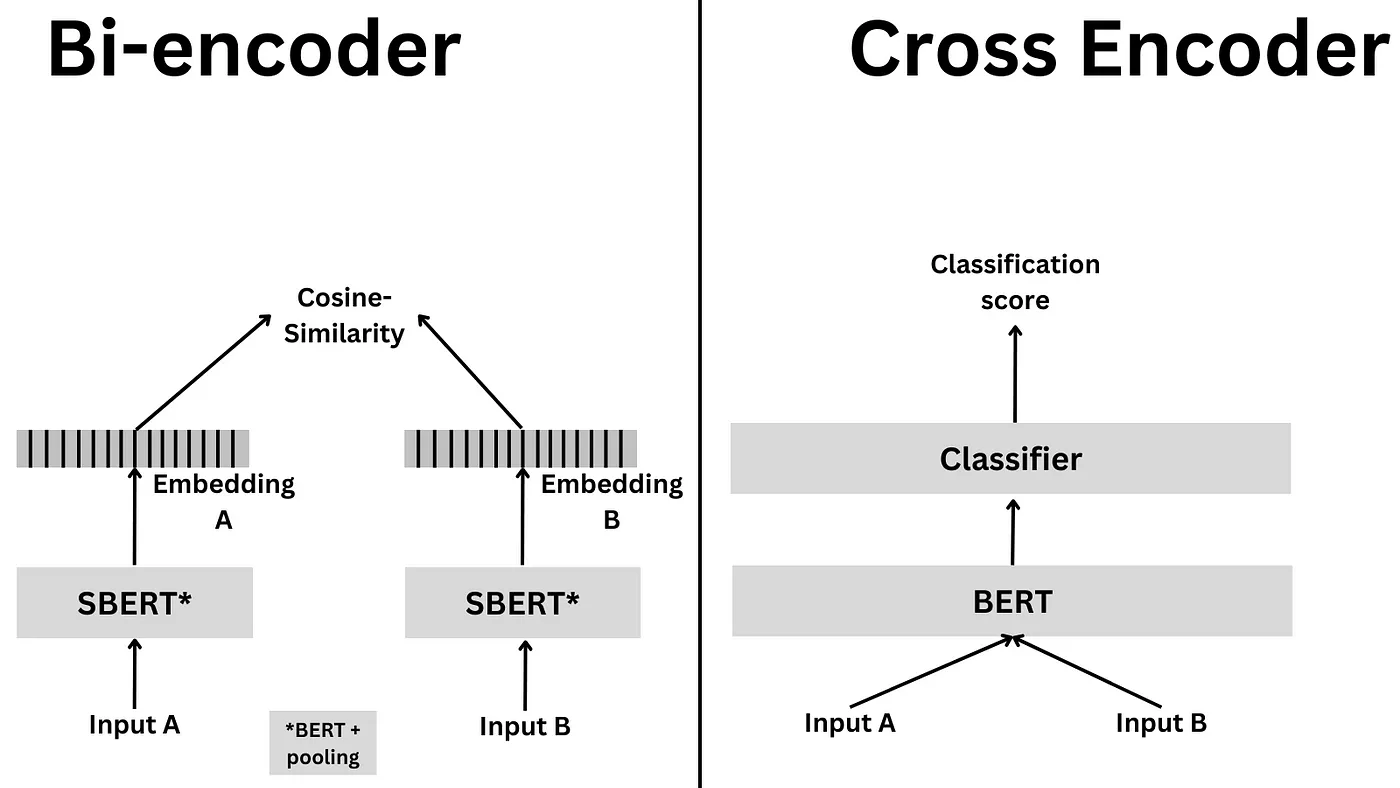

# Imports

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

try:
  import faiss
except:
  !pip install -q faiss-cpu
  import faiss

# Sata (Simulated Data)

In [ ]:
# Posts dataset
posts_data = {
    'post_id': [1, 2, 3, 4, 5, 6],
    'post_text': [
        "Amazing rooftop bar with sunset views",
        "Hidden speakeasy with great cocktails",
        "Cozy cafe with matcha lattes",
        "Rooftop brunch spot with live music",
        "Vegan-friendly brunch place near Queens",
        "Trendy cocktail bar in Williamsburg"
    ],
    'tags': [
        "rooftop, bar",
        "speakeasy, cocktails",
        "cafe, matcha",
        "rooftop, brunch",
        "vegan, brunch",
        "cocktail, bar"
    ],
    'category': ["bar", "bar", "cafe", "brunch", "restaurant", "cocktail"],
    'location_name': ["Brooklyn", "Manhattan", "Manhattan", "Brooklyn", "Queens", "Brooklyn"]
}
posts_df = pd.DataFrame(posts_data)

category_data = {
    'category_id': [1, 2, 3, 4, 5],
    'category_name': ["bar", "brunch", "cafe", "restaurant", "cocktail"]
}
category_df = pd.DataFrame(category_data)

# Users dataset
users_data = {
    'user_id': [101, 102, 103],
    'username': ['alice', 'bob', 'charlie'],
    'friend_list': ['102,103', '101', '101,102'],
    'favorite_categories': ['bar,cafe', 'brunch,restaurant', 'bar,brunch']
}
users_df = pd.DataFrame(users_data)

# Locations dataset
locations_data = {
    'location_id': [1, 2, 3, 4],
    'location_name': ['Brooklyn', 'Manhattan', 'Queens', 'Williamsburg'],
    'latitude': [40.6782, 40.7831, 40.7282, 40.7091],
    'longitude': [-73.9442, -73.9712, -73.7949, -73.9571]
}
locations_df = pd.DataFrame(locations_data)

# Interactions dataset
interactions_data = {
    'interaction_id': [1, 2, 3, 4, 5],
    'user_id': [101, 102, 103, 101, 102],
    'post_id': [1, 2, 2, 4, 5],
    'interaction_type': ['like', 'save', 'like', 'comment', 'like'],
    'timestamp': ['2025-04-20 12:00', '2025-04-20 12:05', '2025-04-20 13:15', '2025-04-21 09:00', '2025-04-21 10:30']
}
interactions_df = pd.DataFrame(interactions_data)

# Embedding Models

## Cross Encoder ReRanking (Just embed the descriptions)

In [ ]:
# 1. Load a pretrained CrossEncoder model
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L6-v2")

# The texts for which to predict similarity scores
query = "Roof lounge in Williamsburg"
descriptions = posts_df["post_text"].to_list()

# 2a. Either predict scores pairs of texts
pairs = [(query, desc) for desc in descriptions]
scores = model.predict(pairs)

posts_df["similarity"] = scores

ranked_posts = posts_df.sort_values(by="similarity", ascending=False).reset_index(drop=True)

# Print ranked results
for i, row in ranked_posts.iterrows():
    print(f"#{i+1}: {row['similarity']:.4f} - {row['post_text']}")

In [ ]:
ranks = model.rank(query, descriptions, return_documents=True)

print("Query:", query)
for rank in ranks:
    print(f"- #{rank['corpus_id']} ({rank['score']:.2f}): {rank['text']}")

##Prepare Text for Embedding

In [ ]:
def create_embedding_input(row):
    return f"{row['post_text']} | Category: {row['category']} | Location: {row['location_name']} | Tags: {row['tags']}"

# Apply create_embedding_input() to each row with apply method
posts_df['text_for_embedding'] = posts_df.apply(create_embedding_input, axis=1)

posts_df.head()

In [ ]:
# Regenerate embeddings with the descriptions included
sent_trans_model = SentenceTransformer('all-MiniLM-L6-v2')

all_embeddings = []
for i in tqdm(range(0, len(posts_df), 32), desc="Generating corner embeddings"):
    batch = posts_df['text_for_embedding'].iloc[i : i + 32].tolist()
    batch_embeddings = sent_trans_model.encode(batch)
    all_embeddings.append(batch_embeddings)

all_embeddings = np.vstack(all_embeddings)
embedding_df = pd.DataFrame(
    all_embeddings,
    columns=[f"embed_{i}" for i in range(all_embeddings.shape[1])],
)

# Concatenate with original dataframe
posts_with_embeddings = pd.concat([posts_df, embedding_df], axis=1)
print(f"Generated {posts_with_embeddings.shape[1] - posts_df.shape[1]} embedding dimensions for each post")

In [ ]:
# Example search query
query = "Coffee shop on Upper West Side"
print(f"Query: '{query}'")


def semantic_search(query, posts_with_embeddings, model, top_n=5):
    query_embedding = sent_trans_model.encode([query])[0]
    embedding_cols = [col for col in posts_with_embeddings.columns if col.startswith("embed_")]
    post_embeddings = posts_with_embeddings[embedding_cols].values
    similarities = cosine_similarity([query_embedding], post_embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n]

    result = []
    for idx in top_indices:
        result.append((posts_with_embeddings.iloc[idx], similarities[idx]))
    return result


print("\n=== Semantic Search Results ===")
semantic_results = semantic_search(query, posts_with_embeddings, sent_trans_model)
for post, score in semantic_results:
    print(f"{score:.4f} - {post['post_text']}")

# FAISS

In [ ]:
# In preparation for FAISS, we need to get the iterable with all embeddings
d = all_embeddings.shape[1]


# Create a FAISS index
# IndexFlatL2 is a flat index that uses L2 (Euclidean) distance
# For production, you'd use more efficient indices like IndexIVFFlat TRY THIS LATER
index = faiss.IndexFlatL2(d)
index.add(all_embeddings)

print(f"Built search index with {index.ntotal} vectors of dimension {d}")

# Let's write a function to do similarity search with FAISS
def search_posts(query, index, top_k=5):
    # Embed the Query First!! You need it in vector form to compare with other vectors!!
    query_embedding = sent_trans_model.encode([query])[0].astype('float32').reshape(1, -1)

    # Search the inputted indices for top nearest specified neighbours
    distances, indices = index.search(query_embedding, top_k)

    # Get results
    results = []

    # Now iterate through the nearest neighbours, and with their index, get necessary attributes from original DF!!
    for i, idx in enumerate(indices[0]):
        results.append({
            'Neighbourhood': posts_df.iloc[idx]['location_name'],
            'type': posts_df.iloc[idx]['category'],
            'description': posts_df.iloc[idx]['post_text'],
            'distance': distances[0][i]  # L2 distance (lower is better)
        })

    return results


In [ ]:
# Test some queries
test_queries = [
    'Hidden speakeasy above Five Guys',
    'Chill divebar called with DJ',
    'Cute brunch spot in Central Park',
    'Cramped bar with bad drinks and billiards'
]

for query in test_queries:
    print(f"\nQuery: '{query}'")
    results = search_posts(query, index)
    for i, result in enumerate(results):
        print(f"{i+1}. {result['Neighbourhood']} - {result['type']} in {result['description']}")
        print(f"   Distance: {result['distance']:.4f}")